# Homewok 2: Logistic Regression

Welcome to the course **AI and Deep learning**!

In practice, categorical data are more commonly analyzed, including but not limited to fraud detection, face recognition in Xiamen University and object  detection. As a fundation for categorical data analysis, logistic regression is of great importance in both statistics and deep learning. In the second homework, we would use simulation again to review logistic regression in more details. Computation graph is implicitly used to obtain the derivatives and update the estimated parameters. Hope you enjoy the second homework!  

**Learning Goal**: In this homework, we are going to conduct a simple simulation study based on a logistic regression. After this homework, you will know:
    * How to estimate the model parameters by gradient-based methods. 
    * How Newton-Raphson method works. 
    * How (batch) gradient descent method works. 
    * How important the learning rate is for a (batch) gradient descent method.
    * How to make inference for the parameters in a logistic regression model.



## Table of content
* [1 - Packages](#1)
* [2 - Generate a training dataset](#2)
* [3 - Parameter estimation](#3) 
    * [3.1 - Newton-Raphson method](#3.1)
    * [3.2 - Gradient descent method](#3.2)
* [4 - Statistical inference](#4)
    * [4.1 - Bias, variance and MSE](#4.1)
    * [4.2 - Coverage rate](#4.2)
* [5 - Closer check for the two estimation methods](#5)
* [6 - Additional homework](#6)

<a name='1'></a>
## 1- Packages

In order to finish a task, we need commands from certain **Python** packages. Again, one of the commonly used package is **numpy**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt # for plots
import pandas as pd # for printing tables
import scipy.stats # for quantile calculation when we consider coverage rates
import time # for timing the code

<a name='2'></a>
## 2 - Generate a training dataset

First, we generate a training dataset from a pre-specified logistic regression model. **In order to guarantee that our simulation results are reproducible, we need to control the random seed.** That is, after controlling the seed, others can generate the **SAME** random variables as we did, so our simulation results can be reproduced.

Consider the following logistic regression model 
$$
y^{(i)}\sim\mbox{Bernoulli}\{\pi(x^{(i)})\},\\
\mathrm{logit}\{\pi(x^{(i)})\} = b_0 +w_{00}x^{(1i)}+w_{01}x^{(2i)},
$$
where $\mbox{Bernoulli}(p)$ is a Bernoulli distribution with success probability $p$, $x^{(i)} = (x^{(1i)},x^{(2i)})^T$, $b_0=-0.5$, $w_{00}=0.1$, $w_{01}=-0.1$, $x^{(ki)}\sim N(2,2^2)$ $k=1,2$.
Let us write a function to generate a training dataset of size $n$ with a random number $rn$. 

First, we need a sigmoid function $\sigma(x) = 1/\{1+\exp(-x)\}$, and complete the following function (**DO NOT CHANGE THE EXISTING PARTS**). The following command may be useful, and check the help document for details:

* `np.exp`: Exponential function.

In [2]:
# PLEASE DO NOT CHANGE THE EXISTING CODE
# Provide your code between ``YOUR CODE BEGINS HERE (approximately 1 lines)'' and ``YOUR CODE ENDS''.
def sigmoid(x):
    # x: input     
    
    ### YOUR CODE BEGINS HERE (approximately 1 lines)
    sig = 1/(1 + np.exp(-x))
    ### YOUR CODE ENDS    

    return sig

That is, compete the following function. (**DO NOT CHANGE THE EXISTING PARTS**) The following command may be useful, and check the help document for details:

* `np.random.binomial`: generate normally distributed random variables.

In [3]:
# PLEASE DO NOT CHANGE THE EXISTING CODE
# Provide your code between ``YOUR CODE BEGINS HERE'' and ``YOUR CODE ENDS''.
def train_data_generation(n, rn):
    # n: sample size
    # rn: random seed
    
    # Step 1. Set random seed to be rn
    # Step 2. Generate x of size nX2 from a normal distribution with mean 2 and standard deviation 2
    # Step 3. Calculate z by z=b_0 + Xw_0
    # Step 4. Calculate a by a = \sigma(z)
    # Step 5. Generate 2d y of size nX1
    
    ### YOUR CODE BEGINS HERE (approximately 5--6 lines)
    
    np.random.seed(rn)
    x = np.random.normal(2,2,size=(n,2))
    b_0 = -0.5
    w_0 = np.array([0.1, -0.1]).reshape(-1,1)
    z = (b_0 + np.dot(x, w_0))
    a = sigmoid(z)
    y = np.random.binomial(1,a,size=(n,1))
    
    ### YOUR CODE ENDS
    
    
    return x, y
    

To visualize your data, you may would like to run the following code.

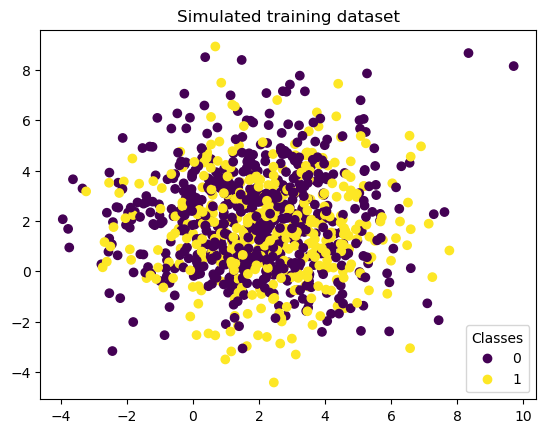

In [4]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
x, y = train_data_generation(1000, 100)

fig, ax = plt.subplots()                         # scatter的参数输入值应该是一个一维数组，
scatter = ax.scatter(x[:,0], x[:,1],  c=y[:,0])  # y是一个特殊的列向量，它实际上被numpy视为一个特殊的二维数组
legend1 = ax.legend(*scatter.legend_elements(),  # 对y切片后，y[:,0] 会变成一个一维数组
                    loc="lower right", title="Classes")
ax.set_title('Simulated training dataset')
plt.show()


<a name='3'></a>
## 3 - Parameter estimation

The estimated parameters $\hat{b}$ and $\hat{w}$ are obtained by minimizing the following cost function,
$$
J(b,w) = -n^{-1}\sum_{i=1}^n\{y^{(i)}\log a^{(i)} + (1-y^{(i)})\log(1-a^{(i)})\}, \tag{1}
$$
where $a^{(i)} = \sigma(z^{(i)})$ and $z^{(i)} = (x^{(i)})^Tw+b$.

Different from linear regression, we do not have a 'normal equation' for a logistic regression model. To find parameters minimizing the cost function (1), we have two different gradient-based methods, including a Newton-Raphson method and a (batch) gradient descent method. We would consider both of them in this homework, and  both methods are iterative. The main difference is that a Hessian matrix is involved for the Newton-Raphson method, but only gradients are required for the gradient descent method (with the Hessian matrix replaced by a **learning rate** $\alpha$). 



For both methods, denote $b^{(0)}$ and $w^{(0)}$ as the initials when estimating both parameters $b_0$ and $w_0=(w_{00},w_{01})^T$.


<a name='3.1'></a>
### 3.1 - Newton-Raphson method

Newton-Raphson method estimates model parameters based on the following steps. 

- Step 1. Initialize $(b^{\{0\}}, w^{\{0\}})$.
- Step 2. Given $(b^{\{t\}}, w^{\{t\}})$ for $t=0,1,\ldots$, obtain 
$$\nabla J(b^{\{t\}},w^{\{t\}}) = n^{-1}\sum_{i=1}^n(a^{(i)}-y^{(i)})\tilde{x}^{(i)}, \quad H(b^{\{t\}},w^{\{t\}})=\frac{\partial^2 J}{\partial (b,w)^T\partial (b,w)}(b^{\{t\}},w^{\{t\}})=n^{-1}\sum_{i=1}^na^{(i)}(1-a^{(i)})\tilde{x}^{(i)}(\tilde{x}^{(i)})^T. $$
Notice that we do not use a superscript '$\{t\}$' for $a^{(i)}$'s. 
- Step 3. Update the model parameters by 
$$
\begin{pmatrix}
b^{\{t+1\}}\\
w^{\{t+1\}}
\end{pmatrix} = \begin{pmatrix}
b^{\{t\}}\\
w^{\{t\}}
\end{pmatrix} - \left\{H(b^{\{t\}},w^{\{t\}})\right\}^{-1}\nabla J(b^{\{t\}},w^{\{t\}})
$$
- Step 4. Go back to Step 2 until convergence.

When we code the Newton-Raphson method, we usually augment the design matrix by a column of 1's as what we did for linear regression models, so that we treat the two parameters by a single one. That is, denote $X=(\tilde{x}^{(1)},\ldots,\tilde{x}^{(1)})^T$, where $\tilde{x}^{(i)} = (1, (x^{(i)})^T)^T$ for $i=1,\ldots,n$. Then, we treat  $\tilde{w}=(b,w^T)^T$ as the single model parameter vector. Please notice that we use $\tilde{X}$ to denote the augmented design matrix in the slides. 


**Note:**
* In Step 2, it is easy to show the following results: ( _check by yourself_ )
$$
\nabla J(\tilde{w}) = \frac{\partial J}{\partial \tilde{w}} = n^{-1}\sum_{i=1}^n(a^{(i)} - y^{(i)})\tilde{x}^{(i)},\\
H(\tilde{w}) = \frac{\partial^2 J(\tilde{w})}{\partial \tilde{w}^T\partial \tilde{w}} = n^{-1}\sum_{i=1}^na^{(i)} (1- a^{(i)})\tilde{x}^{(i)}(\tilde{x}^{(i)})^T,\\
$$
* Summation undermines the computation efficiency, so we consider vectorization. It can be shown that the above results are equivalent to ( _check by yourself_ )
$$
\nabla J(\tilde{w}) =n^{-1}X^T(A-Y), \quad H(\tilde{w}) = n^{-1}X^TWX,
$$
where $Y=(y^{(1)},\ldots,y^{(n)})^T$, $A=(a^{(1)},\ldots,a^{(n)})^T$ and $W = \mbox{diag}((a^{(1)}(1-a^{(1)}),\ldots, a^{(n)}(1-a^{(n)})))$. 

<font color='red'>Notice that multiplying a diagonal matrix is still computationally inefficient. Do you know how to further improve the computation efficiency?</font>
* In Step 4, there are many different metrics to check the convergence. For example, if the Euclidean norm between $(b^{(t)}, w^{(t)})$ and $(b^{(t+1)}, w^{(t+1)})$ is less than a tolerance, say $10^{-4}$.   
* <font color='red'>The maximum iteration is 1\,000</font>, and you can modify this number by yourself. However, it is proved that Newton-Raphson method converges very fast. If you are interested, the Newton-Raphson method achieves quadratic convergence; check relevant references for details.

Now, we code up the Newton-Raphson method mentioned above. <font color='red'>Your output should be a $3\times1$ 2d array.</font>

In [5]:
# PLEASE DO NOT CHANGE THE EXISTING CODE
def NR_est(x,y, tol = 10**(-8)):
    # x: the generated feature vector of size nX2
    # y: the generated feature vector of length n
    # tol: tolerance for convergence criterion
    
    # Step 1. Obtain the sample size
    # Step 2. Augment the feature vector with the intercept term, check the relationship between \tilde{x} and x
    # Step 3. Initialize the parameter for \tilde{w}. Please notice that the size of this parameter is 3X1 2d array
    # Step 4. Initialize a counter for iterations
    # Step 5. Main loop. If number of iterations is less than 1000 and the norm between consecutive estimators is larger than the 
    #         tolerance, then do the following:
    #         Step 5.1. Obtain z using the current parameter
    #         Step 5.2. Obtain a using the current parameter
    #         Step 5.3. Obtain \nabla J
    #         Step 5.4. Obtain the Hessian matrix H
    #         Step 5.5. Update the parameter by the Newton-Raphson method
    #         Step 5.6. add 1 to the counter
    
    ### YOUR CODE BEGINS HERE (approximately 13 lines)
    n = len(y)
    aug_x = np.concatenate((np.ones((n,1)),x),axis=1)

    par = np.zeros((3,1))
    iter_index = 0
    par_prev = np.copy(par)
    while (iter_index<=1000) :
        z = np.dot(aug_x,par)
        A = sigmoid(z)
        
        nabla_J = (1/n) * np.dot(aug_x.T, (A - y))
        w = A * (1-A)
        H_J = (1/n) * (aug_x.T @ (w * aug_x)) 
        
        par -= np.linalg.inv(H_J) @ nabla_J
        if (np.linalg.norm(par_prev-par)<= tol):
            break
        par_prev = np.copy(par)
        iter_index += 1
      
    ### YOUR CODE ENDS
    
    return par


In [6]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
x, y = train_data_generation(50000, 1010)
print('Your estimators by the Newton-Raphson method are:')
print(NR_est(x,y).flatten())
print('The true values are\n (-0.5, 0.1, -0.1)')


Your estimators by the Newton-Raphson method are:
[-0.49261098  0.09692696 -0.09917582]
The true values are
 (-0.5, 0.1, -0.1)


If your Newton-Raphson method is correct, your estimator should be very close to the true value. 

<a name='3.2'></a>
### 3.2 - Gradient descent method

In this section, we consider the gradient descent method, which is mainly based on the following steps. 

- Step 1. Initialize $(b^{\{0\}}, w^{\{0\}})$.
- Step 2. Given $(b^{\{t\}}, w^{\{t\}})$ for $t=0,1,\ldots$, obtain 
$$\nabla J(b^{\{t\}},w^{\{t\}}) = n^{-1}\sum_{i=1}^n(a^{(i)}-y^{(i)})\tilde{x}^{(i)}$$
- Step 3. Update the model parameter by 
$$
\begin{pmatrix}
b^{\{t+1\}}\\
w^{\{t+1\}}
\end{pmatrix} = \begin{pmatrix}
b^{\{t\}}\\
w^{\{t\}}
\end{pmatrix} -\alpha\nabla J(b^{\{t\}},w^{\{t\}}),
$$
where $\alpha$ is a pre-specified learning rate.
- Step 4. Go back to Step 2 until convergence.

Note:
* Again, we should use vectorization to calculate $\nabla J(b^{\{t\}},w^{\{t\}})$ as before.
* The difference between the Newton-Raphson method and the gradient descent method is that a simple learning rate is used for the latter, but a complex Hessian matrix is needed for the former.
* The maximum iteration is 5\,000, which is larger than the one for the Newton-Raphson method above since the gradient descent method converges much slower.

Now, we code up the Newton-Raphson method mentioned above.

In [7]:
# PLEASE DO NOT CHANGE THE EXISTING CODE
def BGD_est(x,y, alpha=10**(-2), tol = 10**(-8)):
    # x: the generated feature vector of length n
    # y: the generated feature vector of length n
    # alpha: learning rate
    # tol: tolerance for convergence criterion
    
    # Step 1. Obtain the sample size
    # Step 2. Augment the feature vector with the intercept term, check the relationship between \tilde{x} and x
    # Step 3. Initialize the parameter for \tilde{w}. Please notice that the size of this parameter is 3X1 2d array
    # Step 4. Initialize a counter for iterations
    # Step 5. Main loop. If number of iterations is less than 5000 and the norm between consecutive estimators is larger than the 
    #         tolerance, then do the following:
    #         Step 5.1. Obtain z using the current parameter
    #         Step 5.2. Obtain a using the current parameter
    #         Step 5.3. Obtain \nabla J
    #         Step 5.4. Update the parameter by the gradient descent method
    #         Step 5.5. add 1 to the counter
    
    ### YOUR CODE BEGINS HERE (approximately 10 lines)
    n = len(y)
    aug_x = np.concatenate((np.ones((n,1)),x),axis = 1)

    par = np.zeros((3,1))
   
    par_prev = np.copy(par)
    iter_index = 0
    while (iter_index <= 5000):
        z = np.dot(aug_x,par)
        A = sigmoid(z)
        
        nabla_J = (1/n) * np.dot(aug_x.T, (A - y))
        
        par -= alpha * nabla_J
        if np.linalg.norm(par-par_prev) <= tol:
            break
        par_prev = np.copy(par)
        iter_index += 1
    ### YOUR CODE ENDS
    
    return par

In [8]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
x, y = train_data_generation(50000, 1010)
print('Your estimators by the gradient descent method are:')
print(BGD_est(x,y).flatten())
print('The true values are\n (-0.5, 0.1, -0.1)')

Your estimators by the gradient descent method are:
[-0.48059312  0.0947909  -0.10113553]
The true values are
 (-0.5, 0.1, -0.1)


<font color='red'>Different from the Newton-Raphson method, we do not expect that estimators are VERY close to the truth, especially when the learning rate and the maximum number of iterations are both small, since performance of the gradient descent method mainly depends on the learning rate. Different learning rates lead to different estimation result. Try some different values by yourself. </font>

<a name='4'></a>
## 4 - Statistical inference
Usually, we conduct 1\,000 Monte Carlo simulations. That is, we generate the training datasets of size $n$ independently 1\,000 times. Then, for each generated training dataset, we estimate the model parameters $(b_0,w_0)$. Then, we pool them together to check their bias, variance and MSE. If we have more than one estimation methods, we can compare when in terms of bias, variance and MSE. In this homework, we have two different methods to estimate the model parameters, and we would like to compare the statistics in this section and computation efficiency in the next section.

<a name='4.1'></a>
### 4.1 - Bias, variance and MSE
We first consider the case with $n=1\,000$, and record all the estimated parameters.


In [9]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
n = 1000
par_NR_result = np.zeros((1000,3))
par_GD_result = np.zeros((1000,3))

for i in range(1000):
    x, y = train_data_generation(n=n, rn=i) # the random seed is set to be i
    par_NR_result[i,:] = NR_est(x,y).flatten()
    par_GD_result[i,:] = BGD_est(x,y).flatten()

First, check the bias of the two methods.

In [10]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
true_par = np.array([-0.5, 0.1, -0.1])
bias_NR = np.mean(par_NR_result,axis = 0) - true_par 
bias_GD = np.mean(par_GD_result,axis = 0) - true_par

bias_all = np.concatenate((bias_NR, bias_GD)).reshape((2,3))
df=pd.DataFrame(bias_all, index=['Newton-Raphson', 'Gradient descent'],columns=['b','w0','w1'])
df.style.set_caption('Bias of the two methods')


,b,w0,w1
Newton-Raphson,0.001986,0.000463,-0.001512
Gradient descent,0.014543,-0.001796,-0.003548


Then, check the variance of the two methods.

In [11]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
var_NR = np.var(par_NR_result,axis = 0)
var_GD = np.var(par_GD_result,axis = 0)

var_all = np.concatenate((var_NR, var_GD)).reshape((2,3))
df=pd.DataFrame(var_all, index=['Newton-Raphson', 'Gradient descent'],columns=['b','w0','w1'])
df.style.set_caption('Variance of the two methods')


,b,w0,w1
Newton-Raphson,0.013567,0.001050,0.001194
Gradient descent,0.012690,0.001020,0.001174


Then, check the MSE of the two methods.

In [12]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
MSE_NR = bias_NR**2 + var_NR
MSE_GD = bias_GD**2 + var_GD

MSE_all = np.concatenate((MSE_NR, MSE_GD)).reshape((2,3))
df=pd.DataFrame(MSE_all, index=['Newton-Raphson', 'Gradient descent'],columns=['b','w0','w1'])
df.style.set_caption('MSE of the two methods')

,b,w0,w1
Newton-Raphson,0.013571,0.001050,0.001197
Gradient descent,0.012901,0.001024,0.001187


If your code is correct, we can observe that the bias of the gradient method is slightly larger than the Newton-Raphson method, and their variance is kind of comparable. Again, try different learning rates and maximum number of iteration for the gradient descent method to observe the difference. 

<a name='4.2'></a>
### 4.2 - Coverage rate

For logistic regression models, we do not have a 'normal equation', and we should ues Taylor expansion to derive the variance of the estimators and use the Slutsky theorem to derive its limiting distribution. In order to obtain meaning results, we need to show consistency of our estimators. All of these materials will be covered in an advanced (statistics or) probability course, and check relevant materials for more details.  

It can be show that the estimators obtained by both methods are consistent, but the convergence of the Newton-Raphson method is much faster. Thus, we only consider the estimators obtained by the Newton-Raphson method in this section.

It can be shown that a variance estimator for the estimated parameter is (check by yourself if you are interested)
$$\left\{n H(\hat{\tilde{w}})\right\}^{-1},\tag{2}$$
where $\hat{\tilde{w}}$ is the estimator obtained by the Newton-Raphson method.

First, we need a function to estimate the covariance matrix. 

In [13]:
# PLEASE DO NOT CHANGE THE EXISTNG CODE
def var_est(x, y, est_par):
    # x: the generated feature vector of length n
    # y: the generated feature vector of length n
    # est_par: the estimated model parameter

    # Step 1. Obtain the sample size
    # Step 2. Augment the feature vector with the intercept term, check the relationship between \tilde{x} and x
    # Step 3. Obtain z using the estimated parameter
    # Step 4. Obtain a using the estimated parameter
    # Step 5. Obtain the Hessian matrix H
    # Step 4. Obtain the estimated covariance matrix by (2) 
    
    ### YOUR CODE BEGINS HERE (approximately 6 lines)
    n = len(y)
    aug_x = np.concatenate((np.ones((n,1)),x),axis = 1 )
    z = np.dot(aug_x,est_par)
    A = sigmoid(z)
    w = A * (1-A)
    H_J = (1/n) * np.dot(aug_x.T ,(w * aug_x)) 
    var_par = np.linalg.inv(n * H_J)
    ### YOUR CODE ENDS
    
    return var_par


By law of large numbers, the variance estimator does not change too much when the sample size is large. Thus, if your function is correct, your variance estimator should approximately matches the sample variance. That is, the following two matrices should be almost the same.

In [14]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
n = 1000
x, y = train_data_generation(n=n, rn=1010)
est_par = NR_est(x,y)
var_par = var_est(x, y, est_par)
print('Your estimated covariance matrix is:')
print(var_par)
print('\nThe sample covariance matrix is:')
print(np.cov(np.transpose(par_NR_result)))

Your estimated covariance matrix is:
[[ 1.24094083e-02 -2.19392895e-03 -1.85139383e-03]
 [-2.19392895e-03  1.08804451e-03 -6.44425239e-05]
 [-1.85139383e-03 -6.44425239e-05  1.05285292e-03]]

The sample covariance matrix is:
[[ 1.35808454e-02 -2.14463486e-03 -2.19886193e-03]
 [-2.14463486e-03  1.05057988e-03 -5.93486811e-05]
 [-2.19886193e-03 -5.93486811e-05  1.19554377e-03]]


It can be shown that under our model setup, the following asymptotic result holds
$$
nH(\hat{\tilde{w}})(\hat{\tilde{w}} - \tilde{w}_0)^T\to N((0,0,0)^T,I_3)
$$
in distribution as $n\to\infty$, where $I_3$ is a $3\times 3$ identity matrix. By this result, we can also check the coverage rates of two-sided 95\% confidence intervals 
$$
(\hat{b}_0 - q_{0.975}\hat{\sigma}_b,\hat{b}_0 - q_{0.025}\hat{\sigma}_b)\\
(\hat{w}_0 - q_{0.975}\hat{\sigma}_{w0},\hat{w}_{0} - q_{0.025}\hat{\sigma}_{w0}),\\
(\hat{w}_1 - q_{0.975}\hat{\sigma}_{w1},\hat{w}_1 - q_{0.025}\hat{\sigma}_{w1}),
$$
where $q_\alpha$ is the $\alpha$-th quantile of a standard normal distribution, and $\hat{\sigma}_b$, $\hat{\sigma}_{w0}$ and $\hat{\sigma}_{w1}$ are the estimated standard error of the estimators. 

If your results are very close to the desired value, you can move to the coverage rates. For each simulated training dataset, we need to check whether the constructed confidence interval covers the true value or not. 

In [15]:
# PLEASE DO NOT CHANGE THE EXISTING CODE
def cr_indicator(x,y,alpha):
    # x: the generated feature vector of length n
    # y: the generated feature vector of length n
    # alpha: significance level. For example, alpha=0.05 corresponds to a 95% two-sided confidence interval.

    # Step 1. Obtain (1-\alpha/2)th quantile of a standard normal distribution.
    # Step 2. Obtain the model estimator
    # Step 3. Obtain the estimated covariance matrix for the estimated parameter
    # Step 4. Obtain the estimated variances for every parameter
    # Step 5. Generate the indicator whether the true value of b_0 lies in the confidence interval
    # Step 6. Generate the indicator whether the true value of w_00 lies in the confidence interval
    # Step 7. Generate the indicator whether the true value of w_00 lies in the confidence interval
    
    ### YOUR CODE BEGINS HERE (approximately 7 lines)
    quan_normal = scipy.stats.norm.ppf(1 - alpha/2)
    
    est_par = NR_est(x,y)
    var_par = var_est(x, y, est_par)
    est_se =  np.sqrt(np.diagonal(var_par))
    
    ind_b = (est_par[0] - quan_normal * est_se[0] <= -0.5) and (-0.5 <= est_par[0] + quan_normal * est_se[0])
    ind_w1 = (est_par[1] - quan_normal * est_se[1] <= 0.1) and (0.1 <= est_par[1] + quan_normal * est_se[1])
    ind_w2 = (est_par[2] - quan_normal * est_se[2] <= -0.1) and (-0.1 <= est_par[2] + quan_normal * est_se[2])
    ### YOUR CODE ENDS    

    
    return np.array([ind_b, ind_w1, ind_w2])
    

In [16]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
cr_est = np.ones((1000,3))-10 # Usually, we should have an NA matrix or a NULL matrix
for i in range(1000):
    x, y = train_data_generation(n=n, rn=i) # the random seed is set to be i
    cr_est[i,:]  = cr_indicator(x, y, alpha = 0.05).flatten()
print('Your coverage rates for the two parameters are:')    
print(np.mean(cr_est, axis = 0)) 

Your coverage rates for the two parameters are:
[0.947 0.956 0.944]


**If your results are close to $1-\alpha = 0.95$, then your code is good.**

<a name='5'></a>
## 5 - Closer check for the two estimation methods
We have mentioned that the convergence of the Newton-Raphson method is much faster than the gradient descent method, and we compare the computation efficiency of the two methods in this section. We still consider the case for $n=1\,000$.

First, we have a closer look at the estimators for both methods in each iteration. Fill in the following blank space to finish the following task:

* Generate a training dataset with sample size $n=1\,000$ with random seed to be 1234
* Set initials to be (0,0,0) for the three parameters.
* ONLY update your estimator for TEN iterations, and the learning rate for the gradient descent method is set to 0.01.


In [17]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
n = 1000
rn = 1234
alpha = 10**(-2)
iter_NR = np.ones((100,3))-10
iter_GD = np.ones((100,3))-10

x, y = train_data_generation(n=n, rn=i) # the random seed is set to be i
aug_x = np.concatenate((np.ones((n,1)),x), axis = 1)

par_NR = np.zeros((3,1))
par_GD = np.zeros((3,1))
iter_index = 0
iter_NR[iter_index,:] = par_NR[:,0]
iter_GD[iter_index,:] = par_GD[:,0]

while iter_index < 99:
    iter_index += 1
    z_NR = aug_x @ par_NR
    A_NR = sigmoid(z_NR)        
    nabla_J_NR = np.transpose(aug_x) @ (A_NR-y) / n
    H_J_NR = np.transpose(aug_x*(A_NR*(1-A_NR))) @ aug_x /n
    par_NR -= np.linalg.inv(H_J_NR) @ nabla_J_NR

    z_GD = aug_x @ par_GD
    A_GD = sigmoid(z_GD)        
    nabla_J_GD = np.transpose(aug_x) @ (A_GD-y) / n
    par_GD -= alpha * nabla_J_GD 
                          
    iter_NR[iter_index,:] = par_NR[:,0]
    iter_GD[iter_index,:] = par_GD[:,0]

We visualize the estimators for $b_0$ based on the two methods.

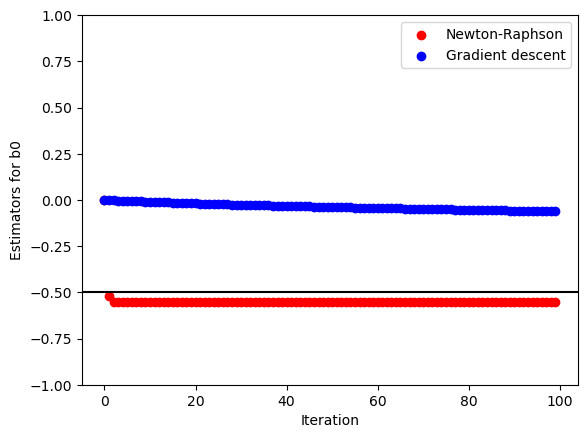

In [18]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
plt.scatter(np.arange(100),iter_NR[:,0], c = 'red',  label='Newton-Raphson')
plt.scatter(np.arange(100),iter_GD[:,0], c = 'blue', label='Gradient descent')
plt.legend(loc="upper right")
plt.axhline(y=-0.5, color='black', linestyle='-')
plt.ylim(-1,1)
plt.xlabel('Iteration')
plt.ylabel('Estimators for b0')
plt.show()


We conclude that the Newton-Raphson method converges very quickly, but it takes more iterations for the gradient descent method to converge.

In [19]:
# PLEASE DO NOT CHANGE THE FOLLOWING CODE
T1 = time.time()
for i in range(100):
    x, y = train_data_generation(n=n, rn=i) # the random seed is set to be i
    par_est =  NR_est(x,y)
T2 = time.time()
print('The Newton-Raphson method takes about %s seconds' % ((T2 - T1)))

T1 = time.time()
for i in range(100):
    x, y = train_data_generation(n=n, rn=i) # the random seed is set to be i
    par_est = BGD_est(x,y)
T2 = time.time()
print('The (Batch) gradient descent method takes about %s seconds' % (T2 - T1))

The Newton-Raphson method takes about 0.514070987701416 seconds
The (Batch) gradient descent method takes about 241.8727478981018 seconds


By comparison, we observe that the Newton-Raphson method is indeed much faster than the gradient descent method. Besides, the Newton-Raphson method generates more accurate estimators than the gradient descent method. <font color='red'>However, the gradient descent method is more commonly used than the Newton-Raphson method, especially in deep learning algorithms, since it is impossible to obtain the Hessian matrix when we have billions of parameters. </font>

<a name='6'></a>
## 6 - Additional homework
When you finish the above basic function, we consider the following additional homeworks. 

* Usually, when we conduct simulation studies, we may consider more than one setup. For simplicity, we only consider different setups for the sample size. Consider $n\in \{500, 1\,000, 1\,500, 2\,000\}$ and use figures to report the following aspects. Plese notice that for all figures, sample sizes index the x-axis. 
   * In one figure, show the coverage rate for $b_0$ as the y-axis and comment your results.
   * In one figure, show the coverage rate for $w_0$ as the y-axis and comment your results.
   * In one figure, show the coverage rate for $w_1$ as the y-axis and comment your results.
   * In one figure, show the computation efficiency of the two estimation methods, and different colors should be used for different methods. Comment your results. 
   * For the case $n=1\,000$, use a figure to show the estimated parameters for $(w_{00},w_{01})$ in 10 iterations. You may set $x$-axis as the estimator for $w_{00}$ and $y$-axis for that of $w_{01}$. Then, use arrows to show how they are updated by different methods. Please use different colors to denote different methods.

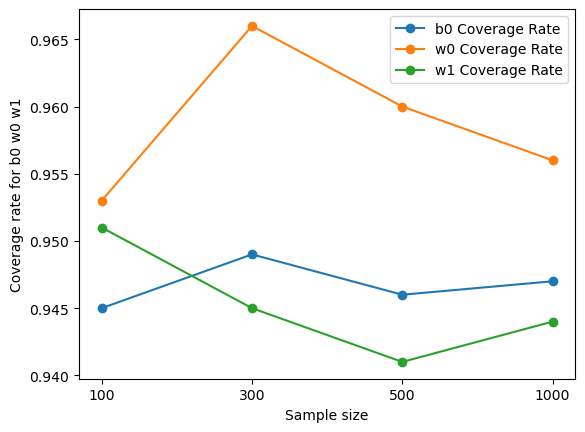

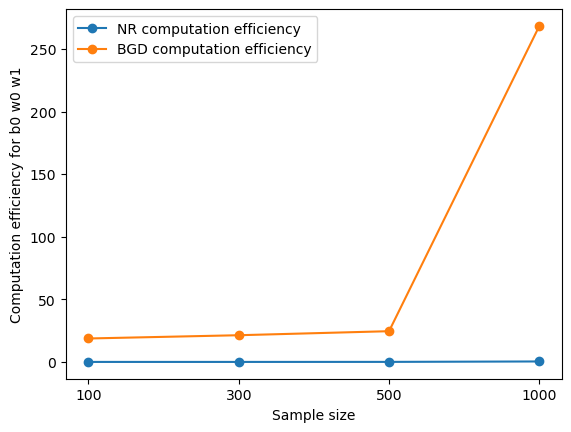

In [23]:
x_axis =[100,300,500,1000] # x-axis index
coverage_rate = np.zeros((len(x_axis),3))
computation_efficiency = np.zeros((len(x_axis),2))

for i in range(len(x_axis)):
    cr_est = np.ones((1000,3))-10 # Usually, we should have an NA matrix or a NULL matrix
    
    for m in range(1000):
        x, y = train_data_generation(n=x_axis[i], rn=m) # the random seed is set to be m
        cr_est[m,:]  = cr_indicator(x, y, alpha = 0.05).flatten()
    
    coverage_rate[i, :] = np.mean(cr_est, axis = 0)
    
    T1 = time.time()
    for m in range(100):
        x, y = train_data_generation(n=x_axis[i], rn=m) # the random seed is set to be i
        par_est =  NR_est(x,y)
    T2 = time.time()
    computation_efficiency[i,0] = (T2-T1)

    T1 = time.time()
    for m in range(100):
        x, y = train_data_generation(n=x_axis[i], rn=m) # the random seed is set to be i
        par_est = BGD_est(x,y)
    T2 = time.time()
    computation_efficiency[i,1] = (T2-T1)
    

b0_cr_est = coverage_rate[:,0]
w0_cr_est = coverage_rate[:,1]
w1_cr_est = coverage_rate[:,2]
NR_time = computation_efficiency[:,0]
BGD_time = computation_efficiency[:,1]

plt.figure(1)

x_positions = np.arange(len(x_axis))

plt.plot(x_positions, b0_cr_est, marker='o', label='b0 Coverage Rate')
plt.plot(x_positions, w0_cr_est, marker='o', label='w0 Coverage Rate')
plt.plot(x_positions, w1_cr_est, marker='o', label='w1 Coverage Rate')

plt.xticks(x_positions,x_axis)
plt.xlabel('Sample size')
plt.ylabel('Coverage rate for b0 w0 w1')
plt.legend()
plt.show()

plt.figure(2)

x_positions = np.arange(len(x_axis))

plt.plot(x_positions, NR_time, marker='o', label='NR computation efficiency')
plt.plot(x_positions, BGD_time, marker='o', label='BGD computation efficiency')

plt.xticks(x_positions,x_axis)
plt.xlabel('Sample size')
plt.ylabel('Computation efficiency for b0 w0 w1')
plt.legend()
plt.show()

# Remarks:
   * As the sample size increases from small to large, the coverage fluctuation of the bias term (b) becomes more pronounced. Specifically, it initially rises and then declines. In contrast, the convergence rate of the weight parameters (w) does not exhibit significant fluctuations.
   * Newton-Raphson method method and Gradient Descent method exhibit a comparable computational efficiency when the sample size is less than or equal to 500. However, when the sample size reaches 1000, we observe a significant decrease in the computational speed of Gradient Descent compared to Newton's method.

In [47]:
n = 1000
rn = 1234
alpha = 10**(-2)
iter_NR = np.zeros((10,3))
iter_GD = np.zeros((10,3))

x, y = train_data_generation(n=n, rn=i) # the random seed is set to be i
aug_x = np.concatenate((np.ones((n,1)),x), axis = 1)

par_NR = np.zeros((3,1))
par_GD = np.zeros((3,1))
iter_index = 0

while iter_index < 10:
    
    z_NR = aug_x @ par_NR
    A_NR = sigmoid(z_NR)        
    nabla_J_NR = np.transpose(aug_x) @ (A_NR-y) / n
    H_J_NR = np.transpose(aug_x*(A_NR*(1-A_NR))) @ aug_x /n
    par_NR -= np.linalg.inv(H_J_NR) @ nabla_J_NR

    z_GD = aug_x @ par_GD
    A_GD = sigmoid(z_GD)        
    nabla_J_GD = np.transpose(aug_x) @ (A_GD-y) / n
    par_GD -= alpha * nabla_J_GD 
    
    iter_NR[iter_index,:] = par_NR.flatten()
    iter_GD[iter_index,:] = par_GD.flatten()
    
    iter_index += 1
    
w0_NR = iter_NR[:, 1]
w1_NR = iter_NR[:, 2]
w0_GD = iter_GD[:, 1]
w1_GD = iter_GD[:, 2]

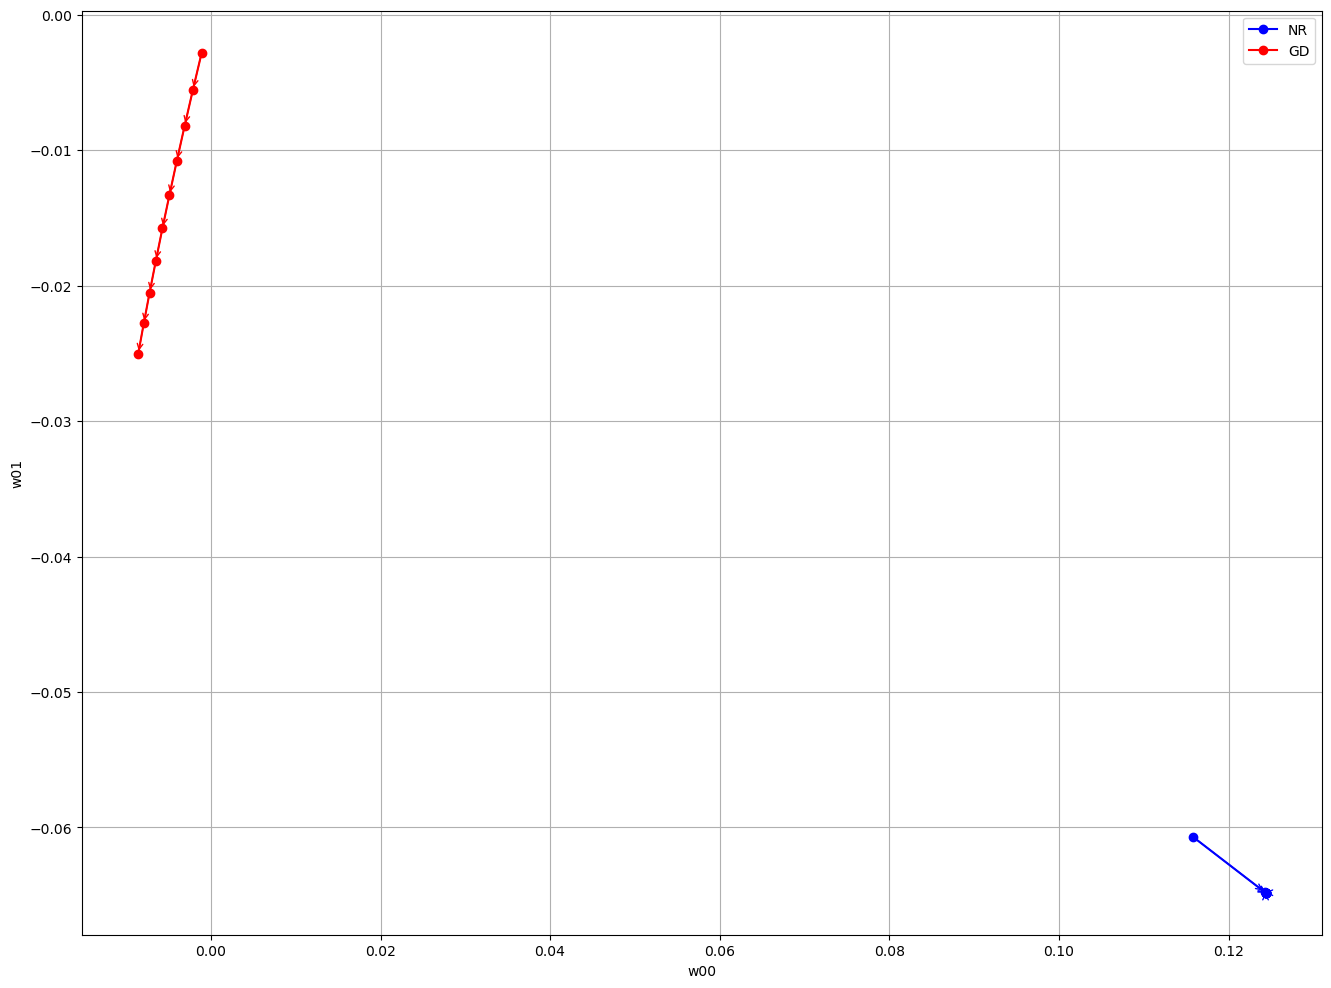

In [48]:

plt.figure(figsize=(16, 12))
plt.xlabel('w00')
plt.ylabel('w01')

# Plot the parameter updates for Newton's method (NR) in blue
plt.plot(w0_NR, w1_NR, '-o', label='NR', color='blue')

# Plot the parameter updates for Gradient Descent (GD) in red
plt.plot(w0_GD, w1_GD, '-o', label='GD', color='red')

# Add arrows to show how parameters are updated in each iteration
for i in range(1, 10):
    plt.annotate('', xy=(w0_NR[i], w1_NR[i]), xytext=(w0_NR[i-1], w1_NR[i-1]),
                 arrowprops={'arrowstyle': '->', 'color': 'blue'})
    plt.annotate('', xy=(w0_GD[i], w1_GD[i]), xytext=(w0_GD[i-1], w1_GD[i-1]),
                 arrowprops={'arrowstyle': '->', 'color': 'red'})

# Add legend
plt.legend()

# Show the plot
plt.grid()
plt.show()
